In [1]:
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.style.use('ggplot')
%matplotlib inline
import os

In [2]:
services = ["Nominatim-API", "GoogleAPI", "Here-API"]


def request_data(endpoint, params):
    endpoint = endpoint
    r = requests.get(endpoint, params)
    return r.json()

top_cities = {
    'Berlin': (13.404954, 52.520008),
    'Köln': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'München': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nürnberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

Select the city from which the data should get loaded

In [3]:
plz_shape_df = gpd.read_file('F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\plz-gebiete.shp',
                             dtype={'plz': str})

plz_region_df = pd.read_csv(
    'F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\zuordnung_plz_ort.csv',
    sep=',',
    dtype={'plz': str}
)
plz_region_df.drop('osm_id', axis=1, inplace=True)
plz_einwohner_df = pd.read_csv(
    'F:\Praxisphase\Localisation\data-parser-staedte\image-generation\csv\plz_einwohner.csv',
    sep=',',
    dtype={'plz': str, 'einwohner': int}
)
germany_df = pd.merge(
    left=plz_shape_df,
    right=plz_region_df,
    on='plz',
    how='inner'
)
germany_df = pd.merge(
    left=germany_df,
    right=plz_einwohner_df,
    on='plz',
    how='left'
)


print(germany_df.head())

     plz                         note  \
0  52538      52538 Gangelt, Selfkant   
1  52538      52538 Gangelt, Selfkant   
2  47559             47559 Kranenburg   
3  52525  52525 Waldfeucht, Heinsberg   
4  52525  52525 Waldfeucht, Heinsberg   

                                            geometry         ort  \
0  POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...     Gangelt   
1  POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...    Selfkant   
2  POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...  Kranenburg   
3  POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...   Heinsberg   
4  POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...  Waldfeucht   

            bundesland  einwohner  
0  Nordrhein-Westfalen      21390  
1  Nordrhein-Westfalen      21390  
2  Nordrhein-Westfalen      10220  
3  Nordrhein-Westfalen      49737  
4  Nordrhein-Westfalen      49737  


Generation Bild: Fehler pro Service. No house number

In [4]:
def no_house_number_per_plz(plz: str, city: str, _service: str):
    res = request_data("http://localhost:10001/noHouseNumber", {'plz': plz, 'service': _service})
    if res == 1.0:
        new_plz = request_data("http://localhost:10001/savedPlzForCity", {'city': city, 'plz': plz})
        if new_plz != "null":
            res = request_data("http://localhost:10001/noHouseNumber", {'plz': new_plz, 'service': _service})
        else:
            print(f"{city} {plz} {new_plz} {res}")
    if res == 1.0:
        print(f"high error rate for response: {city} {plz} {res} {_service}")
        return None
    return res


for service in services:
    germany_df['no_house_number_' + service] = germany_df.apply(
        lambda row: no_house_number_per_plz(row['plz'], row['ort'], service), axis=1)
    print("service: " + service + " finished")

high error rate for response: Harspelt 54617 1.0 Nominatim-API
high error rate for response: Lützkampen 54617 1.0 Nominatim-API
high error rate for response: Sevenig (Our) 54617 1.0 Nominatim-API
high error rate for response: Büdesheim 54610 1.0 Nominatim-API
high error rate for response: Birgel 54587 1.0 Nominatim-API
high error rate for response: Lissendorf 54587 1.0 Nominatim-API
high error rate for response: Spangdahlem 54529 1.0 Nominatim-API
high error rate for response: Wilsum 49849 1.0 Nominatim-API
high error rate for response: Hinzert-Pölert 54421 1.0 Nominatim-API
high error rate for response: Reinsfeld 54421 1.0 Nominatim-API
high error rate for response: Dedenbach 53426 1.0 Nominatim-API
high error rate for response: Königsfeld 53426 1.0 Nominatim-API
high error rate for response: Schalkenbach 53426 1.0 Nominatim-API
high error rate for response: Pünderich 56862 1.0 Nominatim-API
high error rate for response: Hahn 56850 1.0 Nominatim-API
high error rate for response: Raver

In [5]:
no_plz_count = 0


def points_per_plz(plz: str, city: str, _service: str):
    res = request_data("http://localhost:10001/pointsPerPLZ", {'plz': plz, 'service': _service})
    if res == 0:
        new_plz = request_data("http://localhost:10001/savedPlzForCity", {'city': city, 'plz': plz})
        if new_plz != "null":
            res = request_data("http://localhost:10001/pointsPerPLZ", {'plz': new_plz, 'service': _service})
        else:
            print(f"{city} {plz} {new_plz} {res}")
    if res == 0:
        return None
    return res


for service in services:
    germany_df['points_per_plz_' + service] = germany_df.apply(
        lambda row: points_per_plz(row['plz'], row['ort'], service), axis=1)
print(no_plz_count)

0


In [6]:

germany_df_plz = germany_df.groupby('plz').first().reset_index()


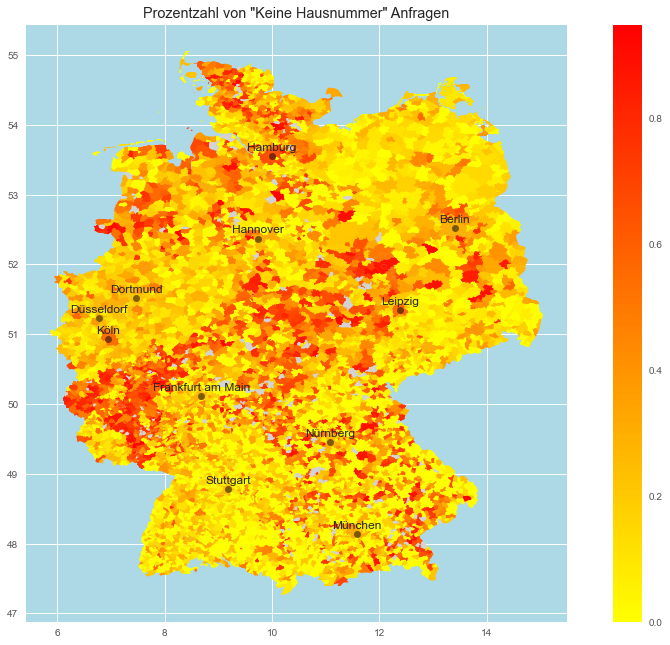

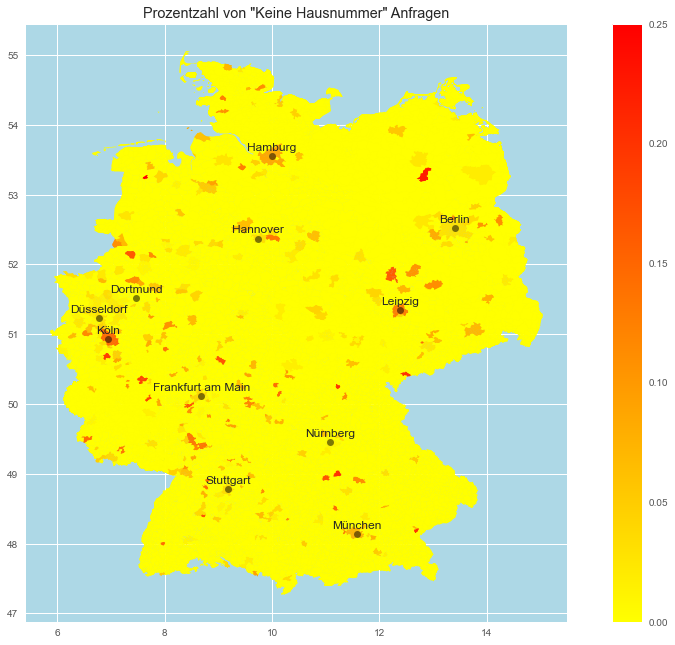

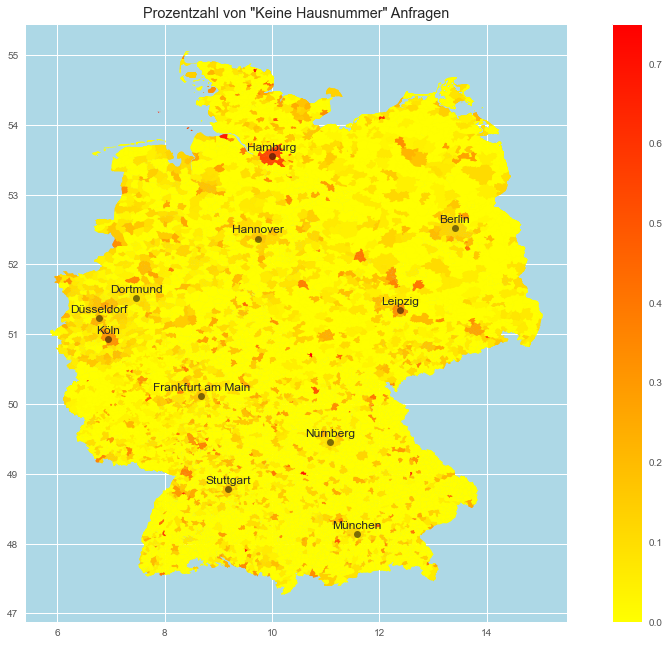

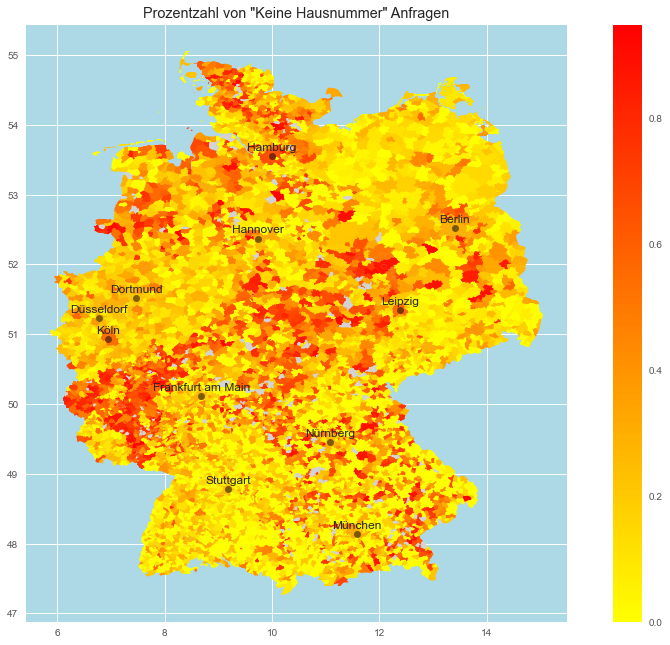

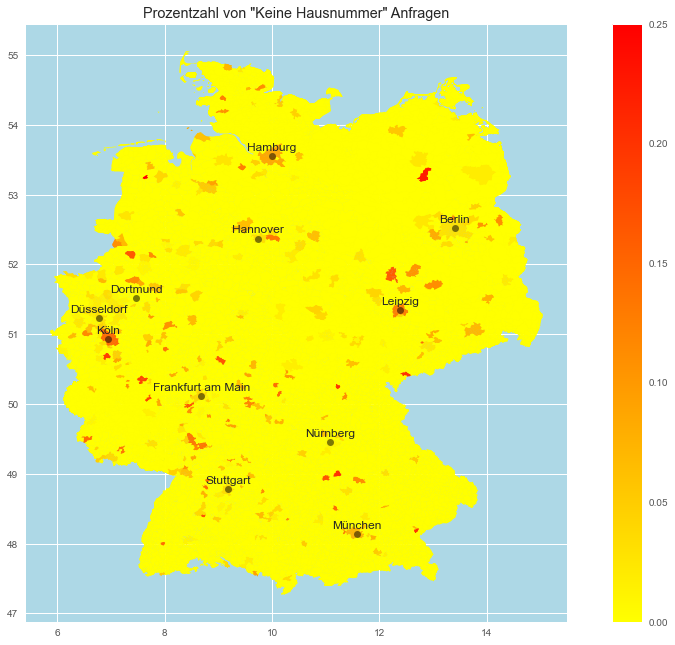

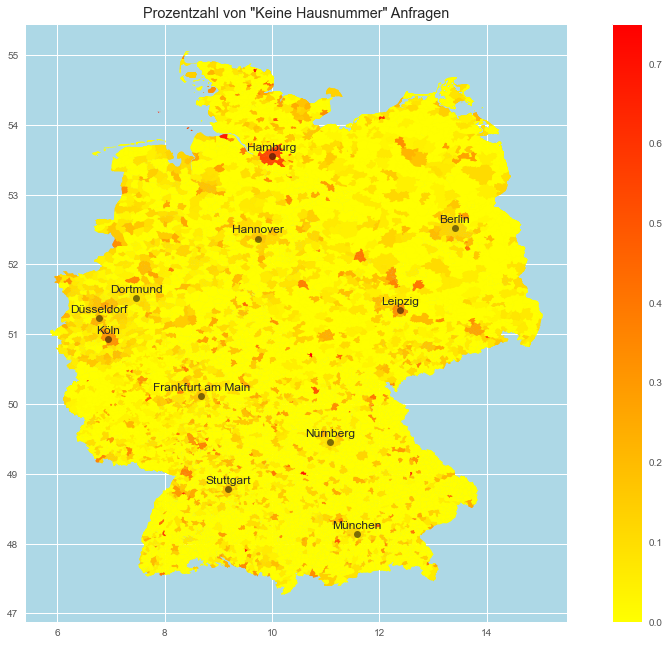

In [12]:
missing_kwds = dict(color='grey', label='No Data')
for service in services:
    plt.rcParams['figure.figsize'] = [16, 11]
    fig, ax = plt.subplots()
    germany_df.plot(
        ax=ax,
        column=f'no_house_number_{service}',
        categorical=False,
        cmap='autumn_r',
        alpha=1,
        missing_kwds= dict(color = "lightgrey",)
    )

    germany_df_plz.plot(
        ax=ax,
        column=f'no_house_number_{service}',
        categorical=False,
        legend=True,
        cmap='autumn_r',
        alpha=1,
        missing_kwds= dict(color = "lightgrey",)
    )
    ax.set(
        title='Prozentzahl von "Keine Hausnummer" Anfragen',
        aspect=1.3,
        facecolor='lightblue'
    )

    for c in top_cities.keys():
    # Plot city name.
        ax.text(
            x=top_cities[c][0],
            # Add small shift to avoid overlap with point.
            y=top_cities[c][1] + 0.08,
            s=c,
            fontsize=12,
            ha='center',
        )
    # Plot city location centroid.
        ax.plot(
            top_cities[c][0],
            top_cities[c][1],
            marker='o',
            c='black',
            alpha=0.5
        )

    plt.savefig(f'no_house_number-{service}.png')

In [8]:
print(list(set(germany_df['bundesland'])))

['Schleswig-Holstein', 'Niedersachsen', 'Sachsen-Anhalt', 'Bremen', 'Bayern', 'Brandenburg', 'Berlin', 'Rheinland-Pfalz', 'Saarland', 'Hamburg', 'Mecklenburg-Vorpommern', 'Baden-Württemberg', 'Sachsen', 'Hessen', 'Thüringen', 'Nordrhein-Westfalen']


In [9]:
germany_df.to_excel(f'germany_df.xlsx', index=False)

ModuleNotFoundError: No module named 'openpyxl'